In [1]:
import os
import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from pathlib import Path
import urllib.request
import zipfile
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

%load_ext autoreload
%autoreload 2

2022-12-11 14:08:06.280984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Download and extract the dataset
The dataset is downloaded from the provided URL and extracted into the 'Dataset' folder

In [2]:
# Download dataset
url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'

# Create dataset folder if it doesn't exist
dataset_folder = './Dataset'
if not os.path.exists(dataset_folder):
    print(dataset_folder, )
    os.mkdir(dataset_folder)

# Download dataset if it doesn't exist
dataset_path = os.path.join(dataset_folder, 'dependency_treebank.zip')

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)
    print("Successful download")    
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        print("Extracting dataset")
        zip_ref.extractall(dataset_folder+'/dependency_treebank')
    os.remove(dataset_path) # Remove zip file


Successful download
Extracting dataset


# Split the data
The data (199 samples in total) is split into a train, validation and test set:
- 100 train samples
- 50 validation samples
- 49 test samples 
The sets are stored in data frames.

In [3]:
# Define split size
TRAIN_SPLIT = 100
VAL_SPLIT = 150

# Define file iterator
def file_iterator():
    data_dir = Path('dependency_treebank')
    for data_file in filter(lambda f: os.path.isfile(data_dir/f) and f.endswith('.dp'), os.listdir(data_dir)):
        yield data_dir/data_file

# Create train, val and test set
data_set = []
split_indexes = []
frame_rows = []
# Iterate over files and perform split
for file in tqdm(file_iterator()):
    document = pd.read_csv(file, sep="\t", names=['token', 'pos'], usecols=[0, 1], engine='python')
    frame_row = {
        'token': list(document['token']),
        'pos': list(document['pos'])
    }
    frame_rows.append(frame_row)

data_frame = pd.DataFrame(frame_rows)

split = ['train']*TRAIN_SPLIT \
        + ['val']*(VAL_SPLIT-TRAIN_SPLIT) \
        + ['test']*(len(frame_rows)-VAL_SPLIT)

assert len(split) == data_frame.shape[0]

data_frame['split'] = split

train_frame = data_frame[data_frame['split']=='train']
test_frame =  data_frame[data_frame['split']=='test']
val_frame =   data_frame[data_frame['split']=='val']

199it [00:00, 233.41it/s]


Check the structure of the constructed data frames

In [4]:
train_frame.head()

,token,pos,split
0,"[In, reference, to, your, Oct., 9, page-one, a...","[IN, NN, TO, PRP$, NNP, CD, NN, NN, ``, NNP, N...",train
1,"[Upjohn, Co., said, it, will, offer, an, early...","[NNP, NNP, VBD, PRP, MD, VB, DT, JJ, NN, NN, T...",train
2,"[Komatsu, Ltd., ,, a, large, integrated, maker...","[NNP, NNP, ,, DT, JJ, VBN, NN, IN, NN, NN, ,, ...",train
3,"[Judging, from, the, Americana, in, Haruki, Mu...","[VBG, IN, DT, NNS, IN, NNP, NNP, POS, ``, DT, ...",train
4,"[Although, his, team, lost, the, World, Series...","[IN, PRP$, NN, VBD, DT, NNP, NNP, ,, NNP, NNP,...",train


In [5]:
test_frame.head()

,token,pos,split
150,"[For, six, years, ,, T., Marshall, Hahn, Jr., ...","[IN, CD, NNS, ,, NNP, NNP, NNP, NNP, VBZ, VBN,...",test
151,"[Boeing, Co., said, it, is, discussing, plans,...","[NNP, NNP, VBD, PRP, VBZ, VBG, NNS, IN, CD, IN...",test
152,"[Intelogic, Trace, Inc., ,, San, Antonio, ,, T...","[NNP, NNP, NNP, ,, NNP, NNP, ,, NNP, ,, VBD, P...",test
153,"[South, Korea, registered, a, trade, deficit, ...","[NNP, NNP, VBD, DT, NN, NN, IN, $, CD, CD, IN,...",test
154,"[Five, things, you, can, do, for, $, 15,000, o...","[CD, NNS, PRP, MD, VB, IN, $, CD, CC, JJR, :, ...",test


In [6]:
val_frame.head()

,token,pos,split
100,"[Lord, Chilver, ,, 63-year-old, chairman, of, ...","[NNP, NNP, ,, JJ, NN, IN, NNP, NNP, NNP, NNP, ...",val
101,"[Meridian, National, Corp., said, it, sold, 75...","[NNP, NNP, NNP, VBD, PRP, VBD, CD, NNS, IN, PR...",val
102,"[Eaton, Corp., said, it, sold, its, Pacific, S...","[NNP, NNP, VBD, PRP, VBD, PRP$, NNP, NNP, NNP,...",val
103,"[Hold, the, Putty, !, With, lipsticks, ,, line...","[VB, DT, NN, ., IN, NNS, ,, NNS, ,, NNS, CC, N...",val
104,"[The, dollar, posted, gains, against, all, maj...","[DT, NN, VBD, NNS, IN, DT, JJ, NNS, NN, ,, VBN...",val


# Tokenization and padding
The data frames are now tokenized and additional padded to have a unit input length 

In [7]:
# Routine to tokenize and pad data to unit length
def tokenize_and_pad(data_frame, trained_tokenizer=None, maxlen=0):
    if trained_tokenizer is None:
        trained_tokenizer = Tokenizer()
        trained_tokenizer.fit_on_texts(data_frame['token'].values)
    
    vocab_size = len(trained_tokenizer.word_index) + 1
    
    encoded_docs = trained_tokenizer.texts_to_sequences(data_frame['token'].values)
    
    if maxlen==0:
        #Use this line to pad to the length that 99% of the documents are included, truncuate the longer docs
        maxlen = int(np.quantile([len(d) for d in encoded_docs], 0.99))

        #Use this line to pad for the max existing document
        #maxlen = max([len(d) for d in encoded_docs])

    padded_docs = pad_sequences(encoded_docs, maxlen=maxlen, padding='post')

    padded_labels = []
    for doc in data_frame['pos']:
        to_pad = maxlen-len(doc)
        
        if to_pad<0:
            t = doc[:maxlen]
        else:
            t = doc + ['0']*(maxlen-len(doc))
        
        padded_labels.append(t)

    return padded_docs, vocab_size, trained_tokenizer, padded_labels, maxlen


# train set, train the tokenizer and determine padding length
train_padded_docs, train_vocab_size, train_tokenizer, train_padded_labels, maxlen = tokenize_and_pad(train_frame)

# val and test set, use the pretrained tokenizer and the max-padding length
val_padded_docs, val_vocab_size, val_tokenizer, val_padded_labels, maxlen = tokenize_and_pad(val_frame, train_tokenizer, maxlen)
test_padded_docs, test_vocab_size, test_tokenizer, test_padded_labels, maxlen = tokenize_and_pad(test_frame, train_tokenizer, maxlen)

# Check if all the shapes have been padded to the correct length
assert train_padded_docs.shape[1] == val_padded_docs.shape[1] == test_padded_docs.shape[1] == maxlen
assert all(len(v)==maxlen for v in train_padded_labels)
assert all(len(v)==maxlen for v in test_padded_labels)
assert all(len(v)==maxlen for v in val_padded_labels)

# Create embedding matrix
First, the pretrained glove-embedding has been downloaded from https://nlp.stanford.edu/projects/glove/ and converted to a dictionary format (100-dimensional embeddings).

In [8]:
embeddings_index = dict()
with open('glove.6B.100d.txt') as f:
    for line in tqdm(f):
        values = line.split()
        embeddings_index[values[0]] = asarray(values[1:], dtype='float32')

print('Loaded %s word vectors.' % len(embeddings_index))

400000it [00:10, 38487.82it/s]

Loaded 400000 word vectors.


Define a function to create an embedding matrix from a given vocabulary, using the previously loaded glove-embeddings

In [9]:
def create_embedding_matrix(tokenizer, vocab_size):
    # load embedding into memory, skip first
    embedding_matrix = zeros((vocab_size, 100))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            # Unknowns are treated by inserting a zero-embedding-vector
            pass
    return embedding_matrix

# Define and train the model
## Encode the POS-labels
We also need to convert the POS labels to a numerical representation (one-hot-encoding).  
Therefore, the label encoder is fitted to the train and validation set. Next, we extract a dictionary of the encoded labels, where we publish the '0' tag to the list of known flags, that has been used to pad the sequences. Unknown flags are marked with another numerical value.

In [10]:
import itertools

# Fit the encoder on train and validation set
all_labels = list(itertools.chain.from_iterable(data_frame[data_frame['split'] != 'test']['pos']))
trained_encoder = LabelEncoder()
trained_encoder.fit(all_labels)

LabelEncoder()

In [36]:
from collections import OrderedDict

le_dict = OrderedDict(zip(trained_encoder.classes_, trained_encoder.transform(trained_encoder.classes_)))
# Add the stop tag to the trained dictionary
le_dict['0'] = len(le_dict)

In [12]:
def encode_labels(labels, le_dict):
    ukn_tag = len(le_dict)
    encoded_Y = []
    for value in labels:
        # Get the encoded value, add the 'ukn_tag' if the tag is not present in the validation or training set
        encoded_doc_labels = [le_dict.get(pos, ukn_tag) for pos in value]
        encoded_Y.append(encoded_doc_labels)
    labels = np_utils.to_categorical(encoded_Y)
    return labels

y_train = encode_labels(train_padded_labels, le_dict)
y_val = encode_labels(val_padded_labels, le_dict)
y_test = encode_labels(test_padded_labels, le_dict)

n_tags = len(le_dict)

# Check for the correct shapes
assert y_train.shape == (TRAIN_SPLIT, maxlen, n_tags)
assert y_val.shape == (VAL_SPLIT-TRAIN_SPLIT, maxlen, n_tags)
assert y_test.shape == (data_frame.shape[0]-VAL_SPLIT, maxlen, n_tags)

## Define the structure and layers of the used model
Here, a sequential model is used, that receives tokens using an Embedding layer (embedding with the loaded glove-embeddings).  
The recurrent structure is implemented using a LSTM layer with 128-units.  
First, show a summary of the data:

In [13]:
train_padded_docs = train_padded_docs.reshape(100, 1892, 1)
val_padded_docs = val_padded_docs.reshape(50, 1892, 1)
test_padded_docs = test_padded_docs.reshape(49, 1892, 1)

print("Trainings data:")
print("   data:", train_padded_docs.shape)
print("   label:", y_train.shape)

print("Validation data:")
print("   data:", val_padded_docs.shape)
print("   label:", y_val.shape)

print("Testing data:")
print("   data:", test_padded_docs.shape)
print("   label:", y_test.shape)

Trainings data:
   data: (100, 1892, 1)
   label: (100, 1892, 46)
Validation data:
   data: (50, 1892, 1)
   label: (50, 1892, 46)
Testing data:
   data: (49, 1892, 1)
   label: (49, 1892, 46)


In [24]:
def create_model(vocab_size,
                 input_length,
                 embedding_matrix,
                 plot_model=False,
                 model_type='base',
                 activation='softmax'):
    # define model
    model = Sequential()
    
    # Input as Embeddings
    # TODO: input length?
    model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=input_length, trainable=False))

    if model_type == 'base':
        # A Bidirectional recurrent layer (LSTM units)
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128, return_sequences=True), input_shape=(None, 100)))
        # Dense layer to fit output to label-vector-size
        model.add(Dense(46, activation=activation))
    elif model_type == 'gru':
        model.add(keras.layers.Bidirectional(keras.layers.GRU(units=128), input_shape=(None, 50)))
        # Dense layer to fit output to label-vector-size
        model.add(Dense(46, activation=activation))
    elif model_type == 'lstm':
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128, return_sequences=True), input_shape=(None, 50)))
        model.add(keras.layers.LSTM(units=128))
        # Dense layer to fit output to label-vector-size
        model.add(Dense(46, activation=activation))
    elif model_type == 'dense':
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(units=128), input_shape=(None, 50)))
        model.add(Dense(128, activation='relu'))
        # Dense layer to fit output to label-vector-size
        model.add(Dense(46, activation=activation))
    else:
        print("No model type specified")
        exit()

    #TODO: Put in train function
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # model.summary()
    if plot_model:
        keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
    return model


Train routine using a bidirectional LSTM layern with 128 units  
Evaluate the models training progress using the validation set

Create model...


2022-12-11 14:13:23.636631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1892, 100)         683200    
                                                                 
 bidirectional (Bidirectiona  (None, 1892, 256)        234496    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1892, 46)          11822     
                                                                 
Total params: 929,518
Trainable params: 246,318
Non-trainable params: 683,200
_________________________________________________________________
Fit model to train data in 15 epochs... 
Epoch 1/10
13/13 [==============================] - 21s 1s/step - loss: 3.4820 - accuracy: 0.7390 - val_loss: 1.6814 - val_accuracy: 0.7417
Epoch 2/10
13/13 [==============================] - 14s 1s/st

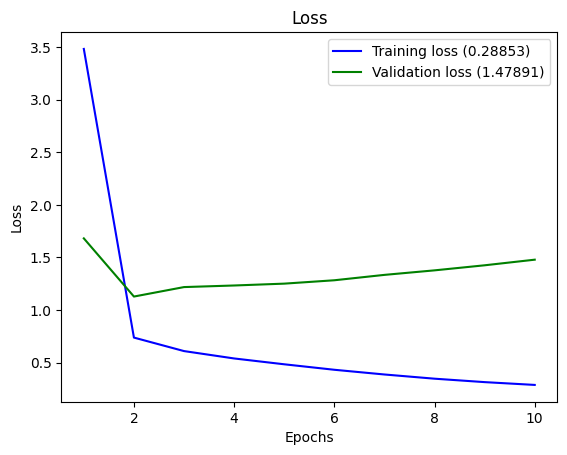

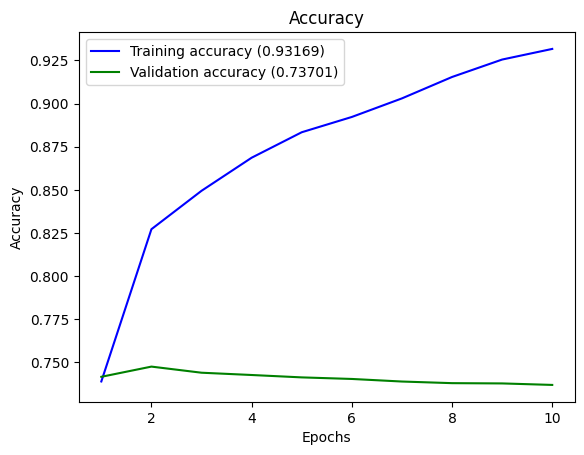

Print full report on validation data...
Print full report on test data...


TypeError: encode_labels() missing 1 required positional argument: 'le_dict'

In [25]:
#Base model
from utils import *

train_embedding_matrix = create_embedding_matrix(train_tokenizer, train_vocab_size)

print("Create model...")
model = create_model(train_vocab_size, maxlen, train_embedding_matrix, plot_model=True)

model.summary()

# val_labels, val_encoder = encode_labels(val_frame)
#val_data = (val_padded_docs, val_labels)

print("Fit model to train data in", 15, "epochs... ")
history = model.fit(train_padded_docs, y_train, validation_data=(val_padded_docs, y_val), epochs=10, verbose=1, batch_size=8)
plot_history(history)


In [54]:
print("Print full report on validation data...")

classes = np.array(list(le_dict.keys()))

y_pred = model.predict(val_padded_docs)

print(y.shape)
print(y_val.shape)

for row in y_pred:
    

Print full report on validation data...
2/2 [==============================] - 2s 716ms/step
(50, 1892, 46)
(50, 1892, 46)


In [ ]:


# predict val data
full_multiclass_report(model=model, x=val_padded_docs, y_true=y_val, classes=classes)

print("Print full report on test data...")

# predict test data
full_multiclass_report(model, test_padded_docs, y_test, classes=classes)

In [66]:
# Base model
from utils import *

train_embedding_matrix = create_embedding_matrix(train_tokenizer, train_vocab_size)
train_labels, train_encoder = encode_labels(train_frame)

print("Create embedding model...")
model = create_model(train_vocab_size, train_embedding_matrix,model_type='gru', plot_model=True)

val_labels, val_encoder = encode_labels(val_frame)
val_data = (val_padded_docs, val_labels)

print("Fit model to train data in", 15, "epochs... ")
history = model.fit(train_padded_docs, train_labels,validation_data=val_data, epochs=15, verbose=1)
plot_history(history)

print("Print full report on validation data...")
# predict val data
full_multiclass_report(model, val_padded_docs, val_labels, val_encoder.inverse_transform(np.arange(45)))

print("Print full report on test data...")
# predict test data
test_labels, test_encoder = encode_labels(test_frame)
full_multiclass_report(model, test_padded_docs, test_labels, test_encoder.inverse_transform(np.arange(45)))

TypeError: encode_labels() missing 1 required positional argument: 'le_dict'

Create embedding model...
Fit model to train data in 15 epochs... 
Epoch 1/15
1413/1413 [==============================] - 6s 3ms/step - loss: 0.9558 - accuracy: 0.7241 - val_loss: 0.6263 - val_accuracy: 0.7978
Epoch 2/15
1413/1413 [==============================] - 4s 3ms/step - loss: 0.5344 - accuracy: 0.8224 - val_loss: 0.5652 - val_accuracy: 0.8051
Epoch 3/15
1413/1413 [==============================] - 4s 3ms/step - loss: 0.4712 - accuracy: 0.8348 - val_loss: 0.5327 - val_accuracy: 0.8174
Epoch 4/15
1413/1413 [==============================] - 4s 3ms/step - loss: 0.4400 - accuracy: 0.8413 - val_loss: 0.5192 - val_accuracy: 0.8131
Epoch 5/15
1413/1413 [==============================] - 4s 3ms/step - loss: 0.4211 - accuracy: 0.8449 - val_loss: 0.5165 - val_accuracy: 0.8187
Epoch 6/15
1413/1413 [==============================] - 4s 3ms/step - loss: 0.4056 - accuracy: 0.8496 - val_loss: 0.5060 - val_accuracy: 0.8240
Epoch 7/15
1413/1413 [==============================] - 4s 3ms/step -

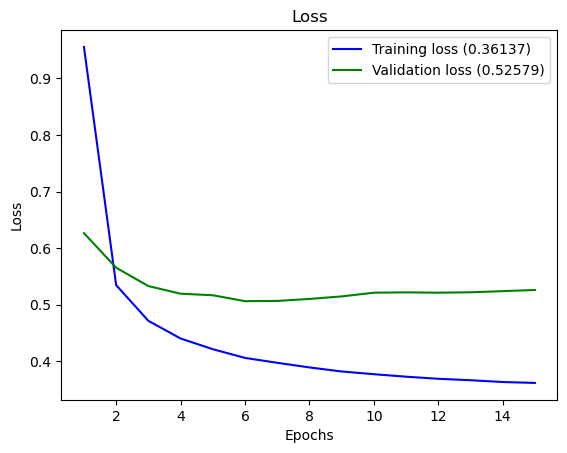

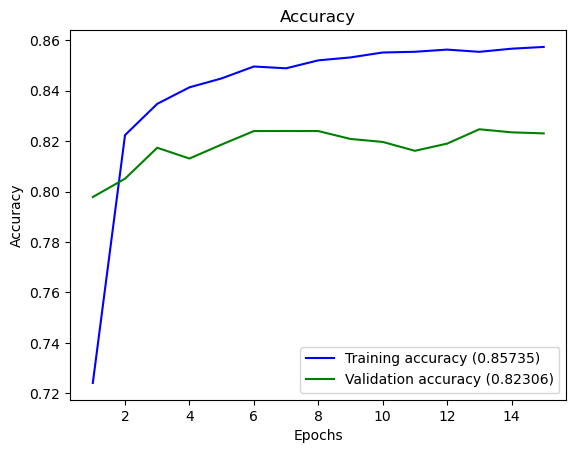

Print full report on validation data...
879/879 [==============================] - 1s 1ms/step
Accuracy : 0.8230648833238474


Classification Report without punctuation
              precision    recall  f1-score   support

       -LRB-    1.00000   1.00000   1.00000        40
       -RRB-    0.88889   1.00000   0.94118        40
          CC    0.99021   0.96810   0.97903       627
          CD    0.98021   0.99157   0.98586       949
          DT    0.98741   0.98858   0.98799      2539
          EX    0.91892   1.00000   0.95775        34
          FW    0.00000   0.00000   0.00000         0
          IN    0.94961   0.98459   0.96679      2986
          JJ    0.77571   0.73474   0.75467      1704
         JJR    0.82759   0.49485   0.61935        97
         JJS    0.80597   0.96429   0.87805        56
          LS    0.00000   0.00000   0.00000         0
          MD    0.97015   1.00000   0.98485       260
          NN    0.82424   0.82051   0.82237      3978
         NNP    0.81

In [90]:
# Base model
from utils import *

train_embedding_matrix = create_embedding_matrix(train_tokenizer, train_vocab_size)
train_labels, train_encoder = encode_labels(train_frame)

print("Create embedding model...")
model = create_model(train_vocab_size, train_embedding_matrix, model_type='lstm', plot_model=True)

val_labels, val_encoder = encode_labels(val_frame)
val_data = (val_padded_docs, val_labels)

print("Fit model to train data in", 15, "epochs... ")
history = model.fit(train_padded_docs, train_labels,validation_data=val_data, epochs=15, verbose=1)
plot_history(history)

print("Print full report on validation data...")
# predict val data
full_multiclass_report(model, val_padded_docs, val_labels, val_encoder.inverse_transform(np.arange(45)))

print("Print full report on test data...")
# predict test data
test_labels, test_encoder = encode_labels(test_frame)
full_multiclass_report(model, test_padded_docs, test_labels, test_encoder.inverse_transform(np.arange(45)))

Create embedding model...
Fit model to train data in 15 epochs... 
Epoch 1/15
1413/1413 [==============================] - 4s 2ms/step - loss: 0.8856 - accuracy: 0.7418 - val_loss: 0.6284 - val_accuracy: 0.7876
Epoch 2/15
1413/1413 [==============================] - 3s 2ms/step - loss: 0.5298 - accuracy: 0.8199 - val_loss: 0.5661 - val_accuracy: 0.8062
Epoch 3/15
1413/1413 [==============================] - 3s 2ms/step - loss: 0.4707 - accuracy: 0.8343 - val_loss: 0.5270 - val_accuracy: 0.8203
Epoch 4/15
1413/1413 [==============================] - 3s 2ms/step - loss: 0.4430 - accuracy: 0.8399 - val_loss: 0.5205 - val_accuracy: 0.8192
Epoch 5/15
1413/1413 [==============================] - 3s 2ms/step - loss: 0.4241 - accuracy: 0.8430 - val_loss: 0.5100 - val_accuracy: 0.8240
Epoch 6/15
1413/1413 [==============================] - 3s 2ms/step - loss: 0.4091 - accuracy: 0.8471 - val_loss: 0.5292 - val_accuracy: 0.8109
Epoch 7/15
1413/1413 [==============================] - 3s 2ms/step -

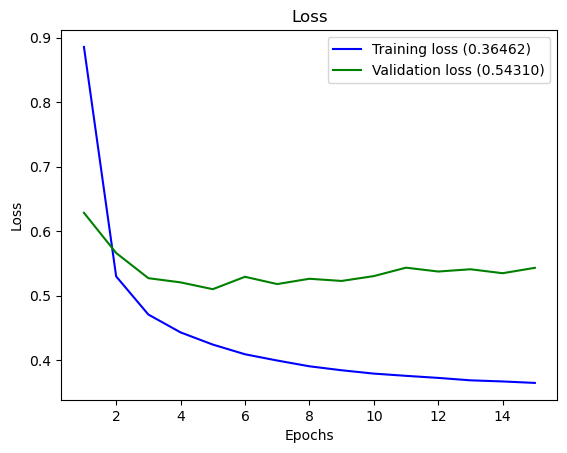

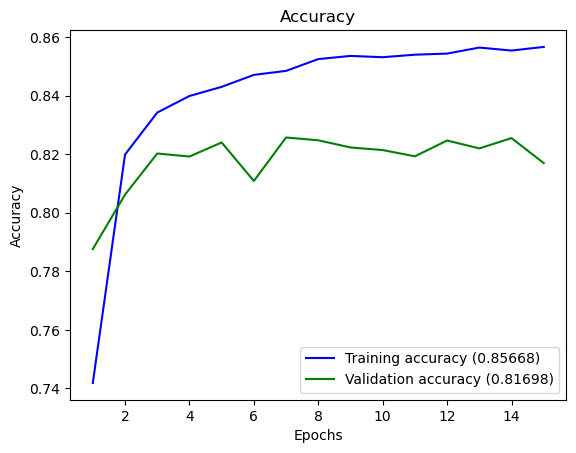

Print full report on validation data...
879/879 [==============================] - 1s 654us/step
Accuracy : 0.8169820717131474

[20  3  3 ... 14 22  3]
[20 20  3 ... 14 22  6]
Classification Report
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000         3
           1    0.00000   0.00000   0.00000       168
           2    1.00000   0.99127   0.99561       229
           3    0.41568   1.00000   0.58726      1410
           4    1.00000   1.00000   1.00000        40
           5    0.97561   1.00000   0.98765        40
           6    0.00000   0.00000   0.00000      1165
           7    0.00000   0.00000   0.00000       168
           8    0.99671   0.96651   0.98138       627
           9    0.98121   0.99052   0.98584       949
          10    0.98741   0.98858   0.98799      2539
          11    0.91892   1.00000   0.95775        34
          13    0.97915   0.92800   0.95289      2986
          14    0.73853   0.75587   0.74710  

In [57]:
# Dense model
from utils import *

train_embedding_matrix = create_embedding_matrix(train_tokenizer, train_vocab_size)
train_labels, train_encoder = encode_labels(train_frame)

print("Create embedding model...")
model = create_model(train_vocab_size, train_embedding_matrix, model_type='dense', plot_model=True)

val_labels, val_encoder = encode_labels(val_frame)
val_data = (val_padded_docs, val_labels)

print("Fit model to train data in", 15, "epochs... ")
history = model.fit(train_padded_docs, train_labels,validation_data=val_data, epochs=15, verbose=1)
plot_history(history)

print("Print full report on validation data...")
# predict val data
full_multiclass_report(model, val_padded_docs, val_labels, val_encoder.inverse_transform(np.arange(45)))

print("Print full report on test data...")
# predict test data
test_labels, test_encoder = encode_labels(test_frame)
full_multiclass_report(model, test_padded_docs, test_labels, test_encoder.inverse_transform(np.arange(45)))

TEST AREA

In [29]:
# import numpy as np
# # predict model test
# predictions = model.predict(test_padded_docs, verbose=1)
# # map predicted labels to words
# predicted_labels = []
# for i in predictions:
#     for word, index in test_tokenizer.word_index.items():
#         if index == np.argmax(i):
#             predicted_labels.append(word)
#             break
# # map actual labels to words
# actual_labels = []
# for i in test_frame['pos'].values:
#     for word, index in test_tokenizer.word_index.items():
#         if index == i:
#             actual_labels.append(word)
#             break
# # create confusion matrix
# confusion_matrix = pd.crosstab(pd.Series(actual_labels), pd.Series(predicted_labels), rownames=['Actual'], colnames=['Predicted'])

44

In [34]:
# import numpy as np
# np.argmax(val_labels[0])
# np.argmax(predictions[0])

35

In [ ]:
model = Sequential()
# Adding the input layer and the first hidden layer
model.add(Dense(16, activation = 'relu', input_dim = 243))
# Adding the output layer
model.add(Dense(units = 1))
model.compile(optimizer = 'adam',loss = 'mean_squared_error')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=40) # Model stop training after 40 epoch where validation loss didnt decrease
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True) #You save model weight at the epoch where validation loss is minimal
train = model.fit((train_X, train_label, batch_size=batch_size),epochs=1000,verbose=1,validation_data=(valid_X, valid_label),callbacks=[es,mc])#you can run for 1000 epoch btw model will stop after 40 epoch without better validation loss